Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Fitting a variational auto-encoder

In part two of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [24]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='data/', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

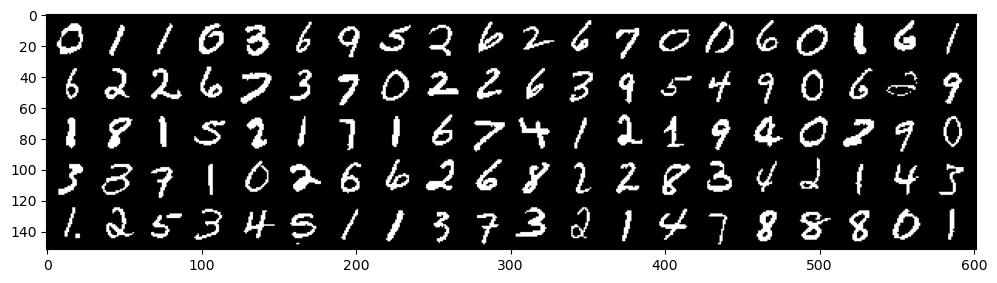

In [25]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))

# TASK 1 (6 points + 2 bonus): Define encoder and decoder networks

We have data $x_i$ and will learn a latent representation $z_i \in \mathbb{R}^{D}$.

To do this we define two different networks, each as an `nn.Module` instance.


* The **Encoder** defines an inference network. It takes a batch of data instances as inputs, and returns a probability distribution $q(z_i | x_i)$ for each $x_i$ in the batch.
* The **Decoder** defines the likelihood in a generative model. It takes a latent value as input, and returns a probability distribution $p(x_i | z_i)$.

## You can use any network architecture you think is appropriate.

Part of your job here is to decide.

* You can get up to 6 points (3 points each) for having an implementation of any non-linear model that runs properly and can be used to fit some sort of VAE. If it doesn't quite work (or if you just implement a linear model, or a poor choice of architecture which leads to bad results) then you will get partial credit.

* You can get 2 additional points if you do something "interesting", by which I specifically mean "more performant". In particular we are looking for architectures which
    - (a) perform better than a feed-forward network, while 
    - (b) having fewer parameters.

In particular: for full *bonus* credit, for a model with `D_latent = 10` you should have fewer than 10,000 parameters each in the encoder and decoder, while still having realistic reconstructions. 


In [26]:
class Encoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, 1, 28, 28).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent

        #Original X.shape = (batch, 1, 28, 28)
        self.first_layer = nn.Sequential(nn.Conv2d(1, 8, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        #Above layer does conv2d which gives us X.shape = (batch, 8, 26, 26) and then ReLu and maxpool to give us X.shape=(batch, 8, 13, 13)

        self.second_layer = nn.Sequential(nn.Conv2d(8, 16, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        #Above layer does conv2d which gives us X.shape = (batch, 16, 11, 11) and then ReLu and maxpool to give us X.shape=(batch, 16, 5, 5)

        #Here we flatten X to acquire X.shape = (batch, 16*5*5) = (batch, 400)
        self.third_layer_flatten = nn.Sequential(nn.Flatten())

        #Finally, do two linear layers for mean and sigma
        self.third_layer_mean = nn.Sequential(nn.Linear(400, D_latent))
        self.third_layer_sigma = nn.Sequential(nn.Linear(400,D_latent))



    def forward(self, X):
        """ Return a distribution q(z | x). 
        
        Remember you can access and variables or `nn.Module` instances defined in the constructor.
        
        INPUT:
        X    : torch.FloatTensor containing zeros and ones; shape = (batch_size, 1, 28, 28)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, D_latent)
        """
        
        #Should I use the re-parametrisation trick?
        #I won't for now

        #Acquire mean and sigma first via convolutional network defined above
        h1 = self.first_layer(X)
        # print("h1 shape = ", h1.shape)
        h2 = self.second_layer(h1)
        # print("h2 shape = ", h2.shape)
        flattened_output = self.third_layer_flatten(h2)
        # print("output shape = ", flattened_output.shape)
        mean = self.third_layer_mean(flattened_output)
        # print("mean shape = ", mean.shape)
        log_sigma = self.third_layer_sigma(flattened_output)
        # print("log sigma shape = ", log_sigma.shape)

        #Sanity check
        assert mean.shape == (X.shape[0], self.D_latent)
        assert mean.shape == log_sigma.shape

        #Define the encoder distribution
        #REMINDER! I am considering the output of self.third_layer_sigma to be the the log sigma^2, thus, need to exp
        sigma = torch.exp(log_sigma)
        encoder_distribution = dist.Normal(loc = mean, scale = sigma)

        return encoder_distribution

In [27]:
class Decoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Decoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, D_latent).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Define your networks here

        #I need to do replicate the encoder but starting from the last layer
        #First make vector z big enough to be reshaped to a matrix via a Linear layer
        self.first_layer = nn.Sequential(nn.Linear(D_latent, 400), nn.ReLU())

        #Now apply transpose convolutional layers to acquire original MNIST shape X.shape = (batch, 1, 28, 28)
        #Current X.shape = (batch, 32, 5, 5)
        self.second_layer = nn.Sequential(nn.ConvTranspose2d(16, 8, kernel_size=6, stride=2, padding=1), nn.ReLU())
        #X.shape = (batch, 16, 11, 11)
        self.third_layer = nn.Sequential(nn.ConvTranspose2d(8, 1, kernel_size = 6, stride=2), nn.Sigmoid())
        #X.shape = (batch, 1, 28, 28), where we have used sigmoid at the end to acquire values that go from 0 to 1 in order to use grayscale        
        
    def forward(self, Z):
        """ Return a distribution p(x | z) 
                
        INPUT:
        X    : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
        """

        # Make sure that the returned value has the right shape! e.g.:
        # return dist.Bernoulli(X_hat.reshape(-1, 1, 28, 28))
        
        #Run Z through the neural network to acquire shape (batch, 1, 28, 28)
        h1 = self.first_layer(Z)
        # print("h1.shape = ", h1.shape)
        #Reshape it as specified above
        h1 = h1.view(-1, 16, 5, 5)
        # print("h1.shape = ", h1.shape)

        #Keep running it through neural network
        h2 = self.second_layer(h1)
        # print("h2.shape = ", h2.shape)

        output = self.third_layer(h2)
        # print("output.shape = ", output.shape)

        #Sanity check
        output = output.reshape(-1,1,28,28)
        # print("output.shape = ", output.shape)

        #Define Bernoulli distribution
        decoder_distribution = dist.Bernoulli(probs = output)

        return decoder_distribution



# TASK 2 (5 points): Define the objective function

You now need to define the ELBO, which we will maximize when estimating parameters in the encoder and decoder.

## Please use a standard normal prior $N(0, I)$ for the latent space.

I.e., let $$z \sim \mathcal{N}(0, I_D)$$ where $D$ is the dimensionality of the latent space.

The `ELBO_VAE` function should return a **single-sample** Monte Carlo estimate of

$$ELBO(x_i) = \mathbb{E}_{q(z_i | x_i)}\left[ \log \left [ \frac{p(z_i)p(x_i | z_i)}{q(z_i | x_i)} \right ] \right ]$$

where $q(z_i | x_i)$ and $p(x_i | z_i)$ are returned by the `Encoder` and `Decoder` classes you defined above.

Note that I have written this as the **per-datapoint** ELBO. 

For ease of inspecting your code, please have your `ELBO_VAE` function below return a Torch vector, i.e. a tensor of shape `(batch_size,)`, containing the per-datapoint ELBO values.


In [28]:
def ELBO_VAE(enc, dec, X):
    """
    
    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28)
    
    
    OUTPUT: a torch.FloatTensor of shape = (batch_size, ) containing the estimate 
            of the per-datapoint ELBO for every data point in the batch.
    
    """
    #Create Z via encoder
    Z_distribution = enc(X)
    Z = Z_distribution.rsample()
#     print("Z.shape = ", Z.shape)
    #Define prior distribution
    prior_distribution = dist.Normal(loc = torch.zeros(enc.D_latent), scale = torch.ones(enc.D_latent))

    #Acquire all needed quantities
    log_prior_probability = prior_distribution.log_prob(Z).sum(dim=1) #Should I sample X.shape[0]? No right?
    encoder_probability = Z_distribution.log_prob(Z).sum(dim=1)

    decoder_distribution = dec(Z)
    decoder_probability = decoder_distribution.log_prob(X).sum(dim=(1,2,3))

#     print("log prior probability: ", log_prior_probability)
#     print("log decoder: ", decoder_probability)
#     print("log encoder: ", encoder_probability)
    #Thus final answer is below
    elbo_vector = log_prior_probability + decoder_probability - encoder_probability

    return elbo_vector

# Train the VAE and look at the results

The following code to train and run the VAE has already been written for you. 

You can use it to evaluate whether or not your model is working as you might expect, and for experimenting with its behavior as you change different parameters.

You should't have to change the two following cells. Feel free to modify them (e.g. for adding debugging information), but be aware that I will test your implementations with substantially similar code. So, your code should be runnable by calling these cells as-is.

In [29]:
# Try modifying this and seeing how it affects performance!
D_latent = 10

enc = Encoder(D_latent)
dec = Decoder(D_latent)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [30]:
print(sum([a.numel() for a in enc.parameters()]))
print(sum([a.numel() for a in dec.parameters()]))

9268
9305


In [31]:
def run_training(N_epochs, enc, dec):
    """ Outer loop for training the VAE 
    
        Calls your `ELBO_VAE` function!
    """
    for epoch in range(N_epochs):
        train_loss = 0.0
        for (X, _) in train_loader:
            opt_vae.zero_grad()
            
            # Call you ELBO implementation
            elbos = ELBO_VAE(enc, dec, X)
            
            # Please don't break the following assertion (check your return shape!)
            batch_size = X.shape[0]
            assert elbos.shape == (batch_size,)
            
            # The loss is the sum of the negative per-datapoint ELBO
            loss = -elbos.sum()
            loss.backward()
            opt_vae.step()
            train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
        print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

In [32]:
# ignore this cell (placeholder)


In [33]:
N_epochs = 50 # Note that you may want to run more epochs!
run_training(N_epochs, enc, dec)

Epoch 0, train loss = 20848.7276
Epoch 1, train loss = 12441.6953
Epoch 2, train loss = 11562.9995
Epoch 3, train loss = 11147.9995
Epoch 4, train loss = 10884.6267
Epoch 5, train loss = 10685.8752
Epoch 6, train loss = 10535.9647
Epoch 7, train loss = 10422.8677
Epoch 8, train loss = 10329.1072
Epoch 9, train loss = 10249.2596
Epoch 10, train loss = 10185.0728
Epoch 11, train loss = 10127.4693
Epoch 12, train loss = 10079.7347
Epoch 13, train loss = 10038.5799
Epoch 14, train loss = 9994.7743
Epoch 15, train loss = 9960.7403
Epoch 16, train loss = 9928.2838
Epoch 17, train loss = 9900.9964
Epoch 18, train loss = 9879.0075
Epoch 19, train loss = 9851.0363
Epoch 20, train loss = 9830.1668
Epoch 21, train loss = 9812.6899
Epoch 22, train loss = 9791.3261
Epoch 23, train loss = 9775.3214
Epoch 24, train loss = 9763.5532
Epoch 25, train loss = 9743.9751
Epoch 26, train loss = 9730.6907
Epoch 27, train loss = 9714.3158
Epoch 28, train loss = 9707.9807
Epoch 29, train loss = 9695.5273
Epoch 

## Do reconstructions look like the input?

Reconstruction accuracy: 0.95


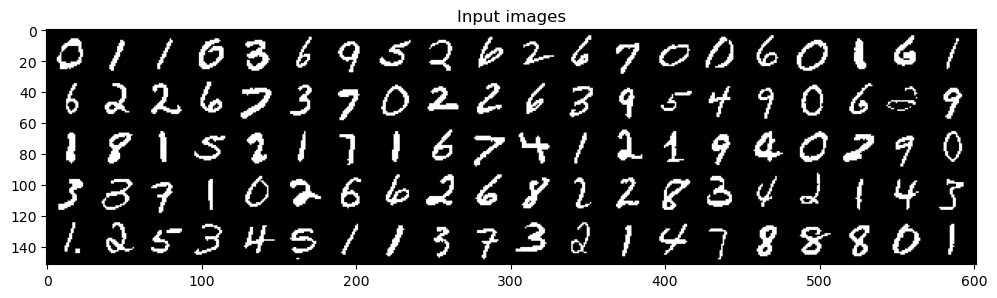

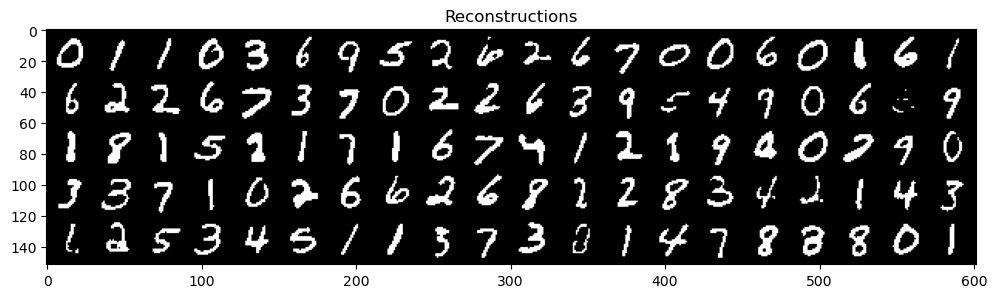

In [34]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
    plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean.round(), nrow=20).permute(1,2,0))
    
print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

## Do randomly generated samples look coherent?

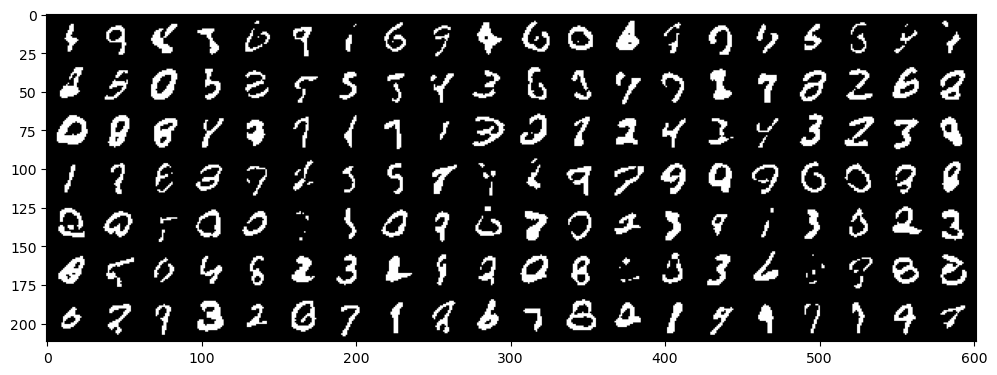

In [35]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

## What does the latent space look like?

Note that this will only give sensible plots for very low-dimensional latent spaces. It works best if the latent space is actually 2d. Otherwise, it will plot a 2d cross-section that may or may not be informative.

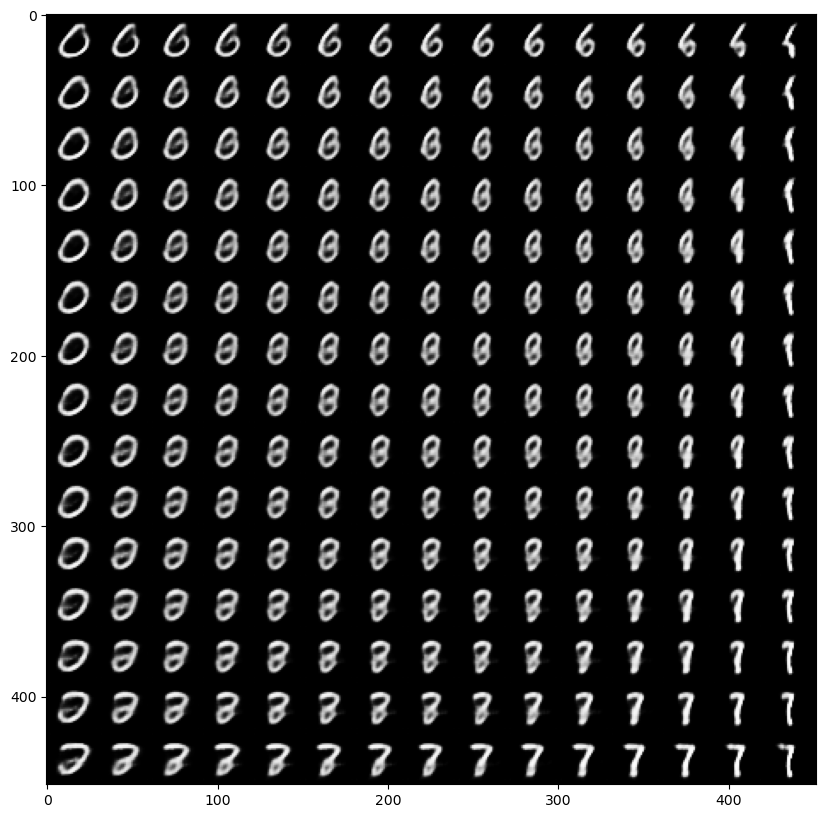

In [36]:
def plot_2d_latent(encoder, decoder):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
    points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
    XX, YY = torch.meshgrid(points, points)
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    with torch.no_grad():
        out = dec(XXYY @ W).mean
    plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
out = plot_2d_latent(enc, dec)

In [37]:
# feel free to try out other things here -- for example, interpolation in the latent space between two digits

In [38]:
# grading


In [39]:
# grading


In [40]:
# grading


In [41]:
# grading


In [42]:
# grading


In [43]:
# grading


In [44]:
# grading
